# Описание исследования

Проводим работу с табличными данными, в которых представлена информация о стартапах, которые функционировали в период с 1980 по 2018 годы. Нужно предсказать, какие из них закроются, а какие нет. Соревнование проводится на популярной платформе Kaggle, что позволит не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой. 

# Цель исследования

- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

# Этапы исследования

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

# Описание данных

Датасет состоит из двух файлов: 
- тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). 
- Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. 
Временной период - '1970-01-01' по '2018-01-01'. 
Дата формирования выгрузки - '2018-01-01'

- `kaggle_startups_train_27042024.csv` - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- `kaggle_startups_test_27042024.csv` - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
- `kaggle_startups_sample_submit_27042024.csv` - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed']. 

**Описание полей данных**
- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий)
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

In [1]:
! pip install phik -q
! pip install shap -q
! pip install -U scikit-learn -q
! pip install seaborn --upgrade -q
! pip install missingno -q

In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [3]:
import os
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

In [4]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", "{:.3f}".format)

In [6]:
def preprocessing(df):
    print('Изучение данных датафрейма "\n')
    print("Вывод первых 5 строк \n")
    display(df.head(5))
    print("-" * 100)
    print(f"Размерность датафрейма, составляет - {(df.shape)}")
    print("-" * 100)
    print("Общая информация:\n")
    display(df.info())
    print("-" * 100)
    print("Описательная статистика:\n")
    display(df.describe())
    print("-" * 100)
    df.isna().sum()
    print("Проверка на наличие явных дубликатов:\n")
    display(df.duplicated().sum())
    print("-" * 100)
    print("Вывод количества уникальных значений")
    display(pd.DataFrame(df.apply(lambda x: x.nunique())))

In [7]:
pth1 = "./datasets/kaggle_startups_train_27042024.csv"
pth2 = "./datasets/kaggle_startups_test_27042024.csv"

if os.path.exists(pth1):
    # Тренировочная выборка:
    df_ks_train = pd.read_csv(
        pth1,
        parse_dates=["founded_at", "first_funding_at", "last_funding_at", "closed_at"],
    )
    if os.path.exists(pth2):
        # Тестовая выборка:
        df_ks_test = pd.read_csv(pth2)
    else:
        print("Something is wrong")

Выведем первоначальную информацию о датафрейме с тренировочными данными

In [8]:
preprocessing(df_ks_train)

Изучение данных датафрейма "

Вывод первых 5 строк 



,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.000,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


----------------------------------------------------------------------------------------------------
Размерность датафрейма, составляет - (52514, 13)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at 

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,42445.000,52514.000,52514,52514,52514,4915
mean,18248255.980,1.741,2008-11-04 08:35:44.342460928,2011-07-17 04:55:32.779830016,2012-06-27 16:46:47.936931072,2012-01-17 17:10:42.360121856
min,1.000,1.000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-12-19 00:00:00
25%,336000.000,1.000,2006-09-28 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-10-01 12:00:00
50%,2000000.000,1.000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-10-01 00:00:00
75%,10000000.000,2.000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-30 12:00:00
max,30079503000.000,19.000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-11-12 00:00:00
std,187121675.710,1.375,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



0

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений


,0
name,52513
category_list,22108
funding_total_usd,15551
status,2
country_code,134
state_code,300
region,1036
city,4477
funding_rounds,19
founded_at,5401


Посмотрим количество пропусков в тренировочных данных

In [9]:
nan_counts = df_ks_train.isna().sum()
print(nan_counts)

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64


In [10]:
# Создание объекта осей
fig, ax = plt.subplots(figsize=(18, 4))
# Генерация графика с использованием объекта осей
msno.matrix(df_ks_train, ax=ax, sparkline=False)
# Добавление названия графика
ax.set_title("Матрица пропущенных значений")
# Отображение графика
plt.show()

**Что можно сказать из первоначальных данных:**
- `name` - имеет 1 пропуск, думаю его можно оставить, так как данная колонка у нас отвечает за идентификаторы.
- `category_list`   - список категорий -  имеет большое количество пропусков, подумаем что с ними можно сделать  2465, так же иммет огромное количество категорий, но множество из них разделено знаком |, предлагаю удалить данные и оставить название категории до вышеуказанного символа. Позволит уменьшить количество уникальных категорий.
- `funding_total_usd`   - Общая сумма финансирования в USD - тоже множество пропусков  - 10069, предлагаю заполнить медианными значениями. 
- `status`   - статус. Не имеет проблем в данных
- `country_code`     - код старны - имеет много пропусков 5501, чем заполнить пока не ясно, оставим, так же имеет не так много категорий, переведем в категориальный тип.
- `state_code`      state_code - Код штата    имеет много пропусков  6762, чем заполнить пока не ясно, оставим, так же имеет не большое количество категорий, переведем в категориальный тип. 
- `region`        - региона, много пропусков -  6358, и много категорий. Думаю дальше данные эти не понадобятся для обучения модели, оставим пропуски
- `city`           - город, много пропусков -        6358, соответствует данным по региону. Вообще все пропуски связанные с географическим положением не заполнены в одинх и теж же строках, это можно наглядно увидеть по матрице пропусков. Возможно кто то заполнял только код страны, а остальные данные были не обязательны для заполнения, либо данные о них просто отсутствовали 
- `funding_rounds`  -   Количество раундов финансирования    - Не имеет проблем в данных. Только переведем в int, так как даные числовые.
- `founded_at`       -    Дата основания    - Не имеет проблем в данных.
- `first_funding_at`  -     Дата первого раунда финансирования - Не имеет проблем в данных.
- `last_funding_at`    -      Дата последнего раунда финансирования - Не имеет проблем в данных.
- `closed_at`        -    Дата закрытия стартапа (если применимо) - имеет большое количество пропусков - 47599, что может говорит о том, что большинство из представленных в данных стартапов являются действующими. Данная колонка будет мешать предсказанию, так как нам надо именно предсказать будет ли закрыт стартап или нет, поэтому заполним пропуски датой выгрузки данных и создадим новую синтетическую информацию, а именно `lifetime` - Время существования стартапа в днях, для этого посчитаем количество дней прошедших между датой основания и датой закрытия

Приведем типы данных

In [11]:
df_ks_train = df_ks_train.astype(
    {"funding_rounds": np.int32, "funding_total_usd": np.float32}
)
df_ks_train[df_ks_train.select_dtypes(["object"]).columns] = df_ks_train.select_dtypes(
    ["object"]
).apply(lambda x: x.astype("category"))
df_ks_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  category      
 1   category_list      50049 non-null  category      
 2   funding_total_usd  42445 non-null  float32       
 3   status             52514 non-null  category      
 4   country_code       47013 non-null  category      
 5   state_code         45752 non-null  category      
 6   region             46156 non-null  category      
 7   city               46156 non-null  category      
 8   funding_rounds     52514 non-null  int32         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: category(7), datetime64[ns](4), float32(1), int32(1)
memor

**Поработаем с пропусками в колонке name**

In [12]:
missing_name_row = df_ks_train[df_ks_train["name"].isna()]
missing_name_row

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.000,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-03-31


Удалим ее и сбросим индексы

In [13]:
df_ks_train = df_ks_train.dropna(subset=["name"]).reset_index(drop=True)

Колока name у нас явялется индексами и не нужна для обучения, переведем ее в индексы и проверим данные на дубликаты

In [14]:
df_ks_train.set_index("name", inplace=True)

In [15]:
# Подсчитываем количество дубликатов
duplicates_count = df_ks_train.duplicated().sum()

# Выводим количество дубликатов
print("Количество дубликатов:", duplicates_count)

Количество дубликатов: 10


In [16]:
df_ks_train[df_ks_train.duplicated()]

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
name,,,,,,,,,,,,
theCre8tion,NaN,NaN,operating,KOR,11,Seoul,Seoul,1,2014-01-01,2015-06-01,2015-06-01,NaT
America's Real Deal,Media|News,670000.000,operating,USA,UT,Salt Lake City,Bountiful,1,2014-04-03,2011-08-19,2011-08-19,NaT
Kliptap,Software,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-01,2014-08-25,2014-08-25,NaT
Two to Tango,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-01,2014-01-01,2014-01-01,NaT
MetaPop Inc.,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,NaT
Eve Snow,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2013-01-01,2014-01-01,2014-01-01,NaT
Prześwietl.pl,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-01,2014-01-01,2014-01-01,NaT
Reflectum,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2012-01-01,2012-04-01,2012-04-01,NaT
InterStelNet,NaN,NaN,operating,USA,CA,SF Bay Area,Palo Alto,1,2014-01-01,2014-01-15,2014-01-15,NaT


В основном это пустые данные, удалим эти строчки, так как они не несут важной информации

In [17]:
df_ks_train = df_ks_train.drop_duplicates()

In [18]:
# Проверим на пропуски
df_ks_train.isnull().sum()

category_list         2458
funding_total_usd    10061
status                   0
country_code          5495
state_code            6756
region                6352
city                  6352
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47589
dtype: int64

**Поработаем с колонкой category_list**

В данной колонке очень много уникальных значений, но почти все они имеют разделитиель в качестве знака | , укрупним группы, оставив только первое наименование категории как самое крупное

In [19]:
# Используем .loc[] для обновления столбца 'category_list'
df_ks_train.loc[:, "category_list"] = df_ks_train["category_list"].str.split("|").str[0]
# Подсчитываем количество уникальных категорий
unique_categories = df_ks_train["category_list"].nunique()
# Выводим количество уникальных категорий
print(unique_categories)

707


У нас существенно уменьшилось количество категорий к которым относятся стартапы с 22108 до 707

In [20]:
df_ks_train["category_list"] = df_ks_train["category_list"].fillna("Unknown")

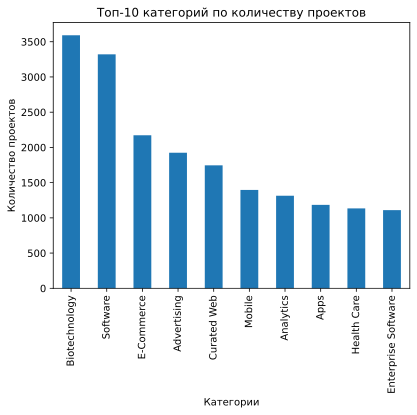

In [21]:
# Создаем фильтрованный датафрейм без категории 'Unknown'
filtered_df = df_ks_train[df_ks_train["category_list"] != "Unknown"]

# Подсчитываем количество проектов по категориям, исключая 'Unknown'
category_counts = filtered_df["category_list"].value_counts().head(10)

# Строим график топ-10 категорий по количеству проектов
category_counts.plot(kind="bar")
plt.title("Топ-10 категорий по количеству проектов")
plt.xlabel("Категории")
plt.ylabel("Количество проектов")
plt.show()

Смогли снизить количество категорий, а так же визуализировали наиболее часто встречающиеся стартапы.

**Поработаем с колонкой status**

In [24]:
# Проверим на пропуски
df_ks_train.status.isnull().sum()

0

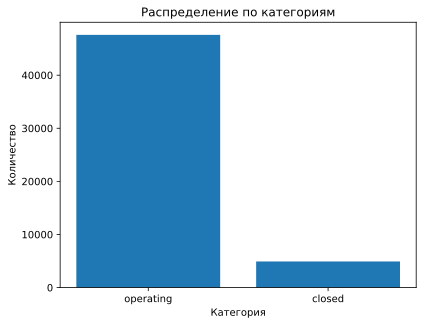

In [25]:
category_counts = df_ks_train.status.value_counts()
plt.bar(category_counts.index, category_counts.values)

# Добавляем название диаграммы и осей
plt.title("Распределение по категориям")
plt.xlabel("Категория")
plt.ylabel("Количество")

# Отображаем график
plt.show()

Пропущенных значений нет, большинство стартапов являются действующими

**Поработаем с колонкой country_code**

In [26]:
unique_categories_country_code = df_ks_train["country_code"].nunique()
unique_categories_country_code

134

In [27]:
new_var = df_ks_train["country_code"].unique()
new_var

['CHE', 'USA', NaN, 'GBR', 'RUS', ..., 'SOM', 'CMR', 'MNE', 'SYC', 'ZMB']
Length: 135
Categories (134, object): ['ALB', 'ARE', 'ARG', 'ARM', ..., 'VNM', 'ZAF', 'ZMB', 'ZWE']

Найдем наиболее часто встречающееся значение

In [28]:
most_common = df_ks_train["country_code"].mode()[0]
most_common

'USA'

Заменим пропуски на заглушку 'Unknown'

In [29]:
# Добавляем 'Unknown' в категории
df_ks_train["country_code"] = df_ks_train["country_code"].cat.add_categories(
    ["Unknown"]
)

# Заменяем NaN на 'Unknown'
df_ks_train["country_code"] = df_ks_train["country_code"].fillna("Unknown")

Построим график ТОП-10 Кодов стран, без учета "Unknown"

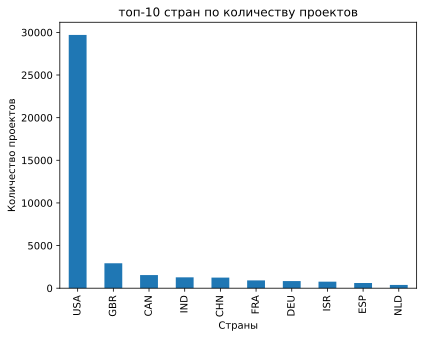

In [30]:
# Фильтруем DataFrame, чтобы исключить строки с 'Unknown'
filtered_df = df_ks_train[df_ks_train["country_code"] != "Unknown"]
# Подсчитываем количество проектов по странам, исключая 'Unknown'
country_counts = filtered_df["country_code"].value_counts().head(10)
# Строим график топ-10 стран по количеству проектов
country_counts.plot(kind="bar")
plt.title("топ-10 стран по количеству проектов")
plt.xlabel("Страны")
plt.ylabel("Количество проектов")
plt.show()

**Поработаем с колонкой state_code**

In [31]:
unique_categories_state_code = df_ks_train["state_code"].nunique()
unique_categories_state_code

300

In [32]:
df_ks_train["state_code"].unique()

['25', 'CA', NaN, 'VA', 'NJ', ..., 'M8', 'J3', 'NU', 'V5', 'U6']
Length: 301
Categories (300, object): ['1', '10', '11', '12', ..., 'Y9', 'Z1', 'Z7', 'Z8']

Имеем множество уникальных значений, где есть и цифры и буквы и их комбинации. Попробуем уменьшить их количество объединив наиболее мелкие категории содержащие до 10 значений в одну категорию Other

In [33]:
counts = df_ks_train["state_code"].value_counts()
threshold = 10  # Порог
df_ks_train["state_code"] = df_ks_train["state_code"].apply(
    lambda x: "Other" if counts[x] < threshold else x
)

In [35]:
df_ks_train["state_code"].nunique()

169

Получили существенное уменьшение категорий, заполним пропуски значением Unknown. Полагаю что данная колонка не понадобится  нам для обучения, поэтому можно просто поставить заглушку чтоб сохранить данные в других столбцах

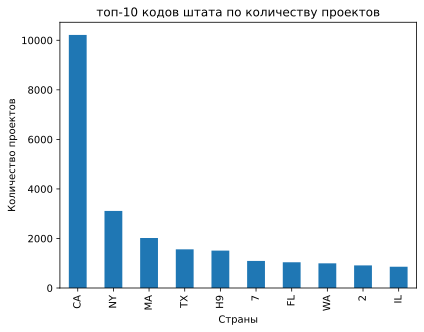

In [41]:
# Фильтруем DataFrame, чтобы исключить строки с 'Unknown' и 'Other'
filtered_df_2 = df_ks_train[
    (df_ks_train["state_code"] != "Other") & (df_ks_train["state_code"] != "Unknown")
]
# Подсчитываем количество проектов по странам, исключая 'Unknown' и 'Other'
state_counts = filtered_df_2["state_code"].value_counts().head(10)
# Строим график топ-10 по количеству проектов
state_counts.plot(kind="bar")
plt.title("топ-10 кодов штата по количеству проектов")
plt.xlabel("Страны")
plt.ylabel("Количество проектов")
plt.show()

Открытые источники говорят что код штата СА - Калифорния, NY - Нью-Йорк, а МА - Массачусетс
В принципе ТОП 3 кодов штатов, подтверждает предыдущий график, что больше всего стартапов в США, и уже внутри США самым оживленным по стартапам является Калифорния

**Поработаем с колонкой funding_total_usd**

In [42]:
df_ks_train["funding_total_usd"].describe()

count         42442.000
mean       18249530.000
std       187128224.000
min               1.000
25%          336108.500
50%         2000000.000
75%        10000000.000
max     30079502336.000
Name: funding_total_usd, dtype: float64

Видим явный выброс, как значение 30 079 502 336, при том что медиана у нас всего 2 000 000 долларов, посмотрим на это значение и предлагаю удалить его.

In [43]:
df_ks_train.loc[df_ks_train["funding_total_usd"] == 30079502336]

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
name,,,,,,,,,,,,
Verizon Communications,Communications Infrastructure,30079502336.000,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,NaT


In [44]:
df_ks_train.drop(
    df_ks_train[df_ks_train["funding_total_usd"] == 30079502336].index, inplace=True
)

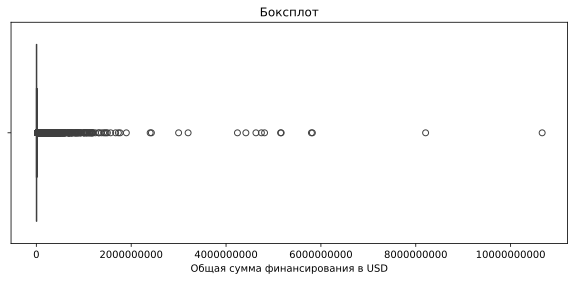

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x="funding_total_usd", data=df_ks_train, orient="h", ax=ax)
# Изменение формата меток на оси X
ax.ticklabel_format(style="plain", axis="x")
ax.set_title("Боксплот")
ax.set_xlabel("Общая сумма финансирования в USD")
plt.show()

Видим очень много выбросов, посмотрим на значения более 20 млд 

In [46]:
df_ks_train.loc[df_ks_train["funding_total_usd"] > 2000000000]

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
name,,,,,,,,,,,,
i-Cube,Application Platforms,4240250112.000,operating,USA,MA,Boston,Cambridge,3,1997-02-09,1998-02-01,1999-06-01,NaT
Uber,Automotive,8207450112.000,operating,USA,CA,SF Bay Area,San Francisco,13,2009-03-01,2009-08-01,2015-09-07,NaT
Cambridge Technology Partners (CTP),Architecture,5150000128.000,operating,Unknown,Unknown,NaN,NaN,2,1990-01-11,1995-01-01,2001-01-01,NaT
COFCO,Agriculture,3200000000.000,operating,CHN,Unknown,NaN,NaN,1,2012-08-16,2014-02-22,2014-02-22,NaT
Suning,Distributors,4630000128.000,operating,CHN,4,Nanjing,Nanjing,1,1996-01-01,2015-08-10,2015-08-10,NaT
Didi Kuaidi,Public Transportation,4417999872.000,operating,CHN,22,Beijing,Beijing,7,2012-09-01,2012-09-01,2015-09-07,NaT
Clearwire,Internet,5820000256.000,operating,USA,WA,Seattle,Kirkland,6,2003-10-01,2001-12-11,2013-02-27,NaT
Cambridge Technology Group,Consulting,10664943616.000,operating,Unknown,Unknown,NaN,NaN,1,1988-01-01,2000-01-01,2000-01-01,NaT
Carestream,Biotechnology,2400000000.000,operating,USA,NY,"Rochester, New York",Rochester,1,2007-01-01,2013-06-12,2013-06-12,NaT


Больше 2 миллиардов долларов было вложено в 15 компаний, однако часть из них существует достаточно много лет и возможно действительно это достаточно успешний стартап и может иметь такое количество финансирования. Не будем пока удалять эти данные.
Заполним пропущенные данные медианой по группе категорий. Так как в category_list у нас есть пропуски, поставим заглушку заполнив данные пропуски значением 'Unknown'. Так как мы не знаем в какие категории могли попасть в эту группу, то заполним ее не медианой по группе 'Unknown', а глобальной медианой, для этого:
Создадим функцию fill_with_median которая проверяет, равна ли категория 'Unknown', и если это так, то она заполняет пропущенные значения в funding_total_usd глобальной медианой. Это гарантирует, что для категории 'Unknown' всегда будет использоваться глобальная медиана, а не медиана по группе 'Unknown'. Для остальных значений сначала проверяет есть ли в группе хоть 1 значение, если есть заполняет медианой по группе, в противном случае глобальной медианой.

In [47]:
# Вычисление глобальной медианы для столбца 'funding_total_usd'
global_median = df_ks_train["funding_total_usd"].median()


def fill_with_median(group, category):
    # Если категория группы - 'Unknown', заполнение NaN значений глобальной медианой
    if category == "Unknown":
        return group.fillna(global_median)
    # Проверка наличия хотя бы одного не-NaN значения в группе
    elif group.notna().any():
        # Заполнение NaN значений медианой группы
        return group.fillna(group.median())
    else:
        # Заполнение NaN значений глобальной медианой
        return group.fillna(global_median)


# Применение функции fill_with_median к каждой группе в столбце 'category_list'
df_ks_train["funding_total_usd"] = df_ks_train.groupby("category_list")[
    "funding_total_usd"
].transform(lambda x: fill_with_median(x, x.name))

In [48]:
df_ks_train.isna().sum()

category_list            0
funding_total_usd        0
status                   0
country_code             0
state_code               0
region                6352
city                  6352
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47588
dtype: int64

**Поработаем с колонкой closed_at**

Заполним closed_at датой выгрузки данных, для последующего создания столбца lifetime - Время существования стартапа в днях

In [49]:
df_ks_train["closed_at"] = df_ks_train["closed_at"].fillna(datetime(2018, 1, 1))

In [50]:
df_ks_train["lifetime"] = (df_ks_train["closed_at"] - df_ks_train["founded_at"]).dt.days
df_ks_train.head(5)

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
name,,,,,,,,,,,,,
Lunchgate,Online Reservations,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01,2923
EarLens,Manufacturing,42935020.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
Reviva Pharmaceuticals,Biotechnology,35456380.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
Sancilio and Company,Health Care,22250000.000,operating,Unknown,Unknown,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
WireTough Cylinders,Manufacturing,3875000.000,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01,2650


closed_at	нам больше не нужен, удалим его

In [51]:
df_ks_train = df_ks_train.drop("closed_at", axis=1)

Проверим, что все удалилось, а нужные нам столбцы остались

In [52]:
df_ks_train.head(5)

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
name,,,,,,,,,,,,
Lunchgate,Online Reservations,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2923
EarLens,Manufacturing,42935020.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,4748
Reviva Pharmaceuticals,Biotechnology,35456380.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,4383
Sancilio and Company,Health Care,22250000.000,operating,Unknown,Unknown,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,5114
WireTough Cylinders,Manufacturing,3875000.000,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2650


Посмотрим визуализации изменения количества раундов финансирования компаний в зависимости от даты их основания

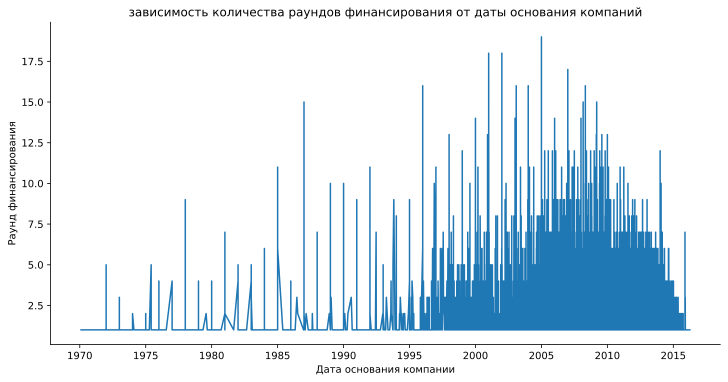

In [57]:
def plot_series(series):
    xs = series["founded_at"]
    ys = series["funding_rounds"]
    plt.plot(xs, ys)


fig, ax = plt.subplots(figsize=(10, 5.2), layout="constrained")
df_sorted = df_ks_train.sort_values("founded_at", ascending=True)
plot_series(df_sorted)
sns.despine(fig=fig, ax=ax)
plt.xlabel("Дата основания компании")
plt.ylabel("Раунд финансирования")
plt.title("зависимость количества раундов финансирования от даты основания компаний")
plt.show()

Данный график может сказать, что компании в основном имеют до 7 раундов финансирования, а большая часть финансирования началась для компаний созданных после 2000 года

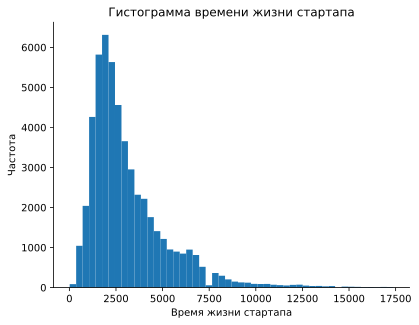

In [61]:
df_ks_train["lifetime"].plot(
    kind="hist", bins=50, title="Гистограмма времени жизни стартапа"
)
plt.xlabel("Время жизни стартапа")
plt.ylabel("Частота")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

Исходя из данной гистограммы видим что время жизни стартапа в основном составляет около 2000 дней, что достаточно много, так же наблюдаются стартапы долгожители более 10 000 дней

**Проведем корреляционный анализ данных**

Используем библиотеку FINK, но исключим данные связанные датами, такими как дата основания, первый и последний раунд финансирования. Основна временная позиция - это время жизни стартапа, думаю это будет основа нашего будущего предсказания

In [63]:
df_ks_train.drop(
    [
        # "region",
        "city",
        "founded_at",
        "first_funding_at",
        "last_funding_at",
    ],
    axis=1,
).phik_matrix(verbose=False)

/Users/skorpioshka/anaconda3/envs/practicum/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1036. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(


,category_list,funding_total_usd,status,country_code,state_code,region,funding_rounds,lifetime
category_list,1.000,0.000,0.241,0.706,0.491,0.785,0.122,0.378
funding_total_usd,0.000,1.000,0.000,0.000,0.000,0.000,0.177,0.049
status,0.241,0.000,1.000,0.228,0.206,0.131,0.099,0.536
country_code,0.706,0.000,0.228,1.000,0.988,1.000,0.102,0.243
state_code,0.491,0.000,0.206,0.988,1.000,1.000,0.200,0.262
region,0.785,0.000,0.131,1.000,1.000,1.000,0.064,0.352
funding_rounds,0.122,0.177,0.099,0.102,0.200,0.064,1.000,0.250
lifetime,0.378,0.049,0.536,0.243,0.262,0.352,0.250,1.000


/Users/skorpioshka/anaconda3/envs/practicum/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable region is large: 1036. Are you sure this is not an interval variable? Analysis for pairs of variables including region can be slow.
  warnings.warn(


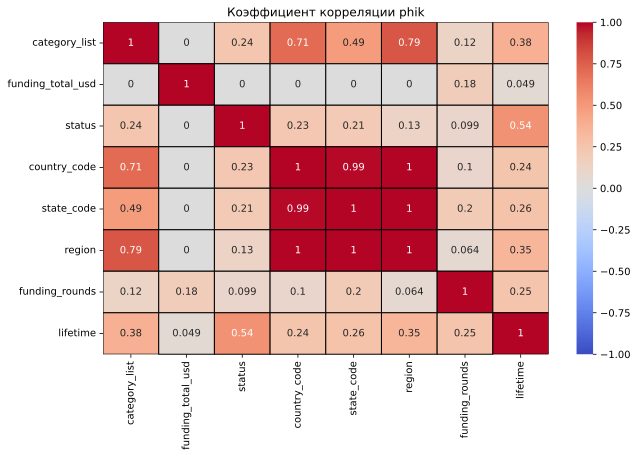

In [65]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_ks_train.drop(
        [
            # "region",
            "city",
            "founded_at",
            "first_funding_at",
            "last_funding_at",
        ],
        axis=1,
    ).phik_matrix(verbose=False),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    linewidths=1,
    linecolor="black",
)
plt.title("Коэффициент корреляции phik")
plt.show()

Наибольшую взаимосвязь видим между целевым признаком количеством дней жизни стартапа - 0,54.

Так же имеется достаточно сильная взаимосвязь между категорией и кодом страны - 0,49, регионов и категорией, кодом страны и категорией больеш 0,7.

При мультиколлинеральноси имеются взаимосвязи т 0.9 до 0.95 по модулю. Такие значения у нас есть, это код страны и код штата, регион и код страны вообще имеют 1, что логично так как данный регион находится в определенной стране. Такие признаки будет мешать находить зависимостити, для обучения модели поэтому из географических данных будем использовать только код страны

## Определение данных необходимых для обучения модели

- status	 - целевой признак
- category_list	- категория
- funding_total_usd	- объем финансирования
- country_code	- код страны
- funding_rounds	- раунд финансирования
- lifetime - время жизни стартапа

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.ensemble import GradientBoostingClassifier

Убедимся что у нас не осталось пропусков в значениях необходимых для обучения

In [67]:
df_ks_train.isna().sum()

category_list           0
funding_total_usd       0
status                  0
country_code            0
state_code              0
region               6352
city                 6352
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

In [74]:
# Фичи для обучения
X = df_ks_train[
    ["category_list", "country_code", "funding_total_usd", "funding_rounds", "lifetime"]
]
y = df_ks_train["status"]  # Метки классов

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [77]:
# Предобработка данных
categorical_features = ["category_list", "country_code"]
numeric_features = ["funding_total_usd", "funding_rounds", "lifetime"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Создание пайплайна с использованием случайного леса в качестве классификатора
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Обучение модели
pipeline.fit(X_train, y_train)

# Оценка модели
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
f1_overall = f1_score(y_test, y_pred, average="weighted")
print(f"Общая F1-метрика: {f1_overall}")

              precision    recall  f1-score   support

      closed       0.84      0.62      0.72       983
   operating       0.96      0.99      0.97      9518

    accuracy                           0.95     10501
   macro avg       0.90      0.81      0.85     10501
weighted avg       0.95      0.95      0.95     10501

Общая F1-метрика: 0.9506774940303475


In [82]:
# Предобработка данных
categorical_features = ["category_list", "country_code"]
numeric_features = ["funding_total_usd", "funding_rounds", "lifetime"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Создание пайплайна с использованием градиентного бустинга в качестве классификатора
pipeline_bust = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

# Обучение модели
pipeline_bust.fit(X_train, y_train)

# Оценка модели
y_pred_bust = pipeline_bust.predict(X_test)
print(classification_report(y_test, y_pred_bust))
f1_overall_bust = f1_score(y_test, y_pred_bust, average="weighted")
print(f"Общая F1-метрика: {f1_overall_bust}")

              precision    recall  f1-score   support

      closed       0.87      0.61      0.72       983
   operating       0.96      0.99      0.98      9518

    accuracy                           0.96     10501
   macro avg       0.92      0.80      0.85     10501
weighted avg       0.95      0.96      0.95     10501

Общая F1-метрика: 0.9514714373308385
